In [1]:
from utils import *
from scipy.linalg import block_diag

In [2]:
clear_previous_simulation()
# define simulation fundamental time step [s]
ts_sim = 0.001

# setup controller parameters
# - system model
model = STM_model()
# - controller sample time [s]
Ts = 0.01
# - number of shooting time intervals 
N  = 50
# - prediction horizon length [s]
T = N*Ts

T_tot = 10 # total simulation time [s]

# model used to simulate the system
sim_model = STM_model()

# Equilibrium point (found in matlab)
V_eq = 4.55 # [m/s] total velocity
beta_eq = 0 #-0.44 # [rad] sideslip angle
r_eq = 0 #1.30 # [rad/s] yaw rate
delta_eq = 0 #-0.13 # [rad] steering angle 
Fx_eq = 0 #46.29 # [N] longitudinal force

# Input bounds
delta_lb = -np.deg2rad(20) # lower bound on steering angle
delta_ub = np.deg2rad(20)  # upper bound on steering angle
Fx_lb = -80 # lower bound on longitudinal force
Fx_ub = 80  # upper bound on longitudinal force

# initial condition
x0 = np.array([4, beta_eq, r_eq])

# define cost weigth matrices
w_V     = 1e2
w_beta  = 5e0
w_r     = 5e0

w_delta = 1
w_Fx    = 1e-2


Q = np.diag([w_V, w_beta, w_r])
R = np.diag([w_delta, w_Fx])


# get state and control dimensions
nx, nu = model.x.rows(), model.u.rows()

# define reference 
# - define reference for the angle and, accordingly, the simulation time Tf
# angle_ref, Tf = piecewise_constant(np.array([np.pi, 0]), np.array([5, 10]), Ts)

V_ref, Tf    = piecewise_constant(np.array([V_eq]), np.array([T_tot]), Ts)
beta_ref, _  = piecewise_constant(np.array([beta_eq]), np.array([T_tot]), Ts)
r_ref, _     = piecewise_constant(np.array([r_eq]), np.array([T_tot]), Ts)
Fx_ref, _    = piecewise_constant(np.array([Fx_eq]), np.array([T_tot]), Ts)
delta_ref, _ = piecewise_constant(np.array([delta_eq]), np.array([T_tot]), Ts)


# - provide a reference for all variables 
# y_ref = np.column_stack((np.zeros((len(angle_ref), 1)), angle_ref.reshape(-1,1), np.zeros((len(angle_ref), nx+nu-2))))
y_ref_nolookahead = np.column_stack((V_ref, beta_ref, r_ref, delta_ref, Fx_ref))
# y_ref_nolookahead = np.column_stack((vx_ref, vy_ref, r_ref, np.zeros((len(vx_ref), nu))))

# - add N samples at the end (replicas of the last sample) for reference look-ahead
y_ref = np.vstack((y_ref_nolookahead, np.repeat(y_ref_nolookahead[-1].reshape(1,-1), N, axis=0)))

# compute the number of steps for simulation
N_steps, N_steps_dt, n_update = compute_num_steps(ts_sim, Ts, Tf)

# configure whether to apply shifting and to enable reference look-ahead
shifting    = False
ref_preview = False

In [3]:
def create_ocp_solver_description(model, N, T, x0) -> AcadosOcp:

    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # define system dynamics model
    ocp.model = model

    # set prediction horizon:
    # tf - prediction horizon length [s]
    # N  - number of intervals in which the prediction horizon is divided 
    ocp.solver_options.tf = T
    ocp.dims.N = N
    ocp.solver_options.N_horizon = N
    
    # get state, control and cost dimensions
    nx = model.x.rows()
    nu = model.u.rows()

    ny = nx + nu 
    ny_e = nx
   
    # define cost type
    ocp.cost.cost_type = 'LINEAR_LS'
    ocp.cost.cost_type_e = 'LINEAR_LS'
    
    ocp.cost.W = block_diag(Q, R)
    ocp.cost.W_e = T/N*Q

    # define matrices characterizing the cost
    ocp.cost.Vx = np.vstack((np.eye(nx), np.zeros((nu, nx))))
    ocp.cost.Vu = np.vstack((np.zeros((nx, nu)), np.eye(nu)))
    ocp.cost.Vx_e = np.eye(nx)
    
    # alternatively, for the NONLINEAR_LS cost type
    #ocp.model.cost_y_expr = ca.vertcat(model.x, model.u)
    #ocp.model.cost_y_expr_e = model.x

    # initialize variables for reference
    ocp.cost.yref = np.zeros((ny,))
    ocp.cost.yref_e = np.zeros((ny_e,))

    # set constraints
    ocp.constraints.idxbu = np.array([0,1]) # indices of the control inputs to be constrained
    ocp.constraints.lbu = np.array([delta_lb, Fx_lb])  # lower bounds on inputs
    ocp.constraints.ubu = np.array([delta_ub, Fx_ub])   # upper bounds on inputs

    # ocp.constraints.idxbu = np.array([1]) # indices of the control inputs to be constrained
    # ocp.constraints.lbu = np.array([-np.deg2rad(20)])  # lower bounds on inputs
    # ocp.constraints.ubu = np.array([np.deg2rad(20)])   # upper bounds on inputs
  

    # initialize constraint on initial condition
    ocp.constraints.x0 = x0

    # set solver options
    # ocp.solver_options.print_level = 1
    ocp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"  #FULL_CONDENSING_QPOASES, PARTIAL_CONDENSING_HPIPM
    ocp.solver_options.hessian_approx = "GAUSS_NEWTON"
    ocp.solver_options.integrator_type = "ERK"
    ocp.solver_options.nlp_solver_type = "SQP" #SQP, SQP_RTI

    # to configure partial condensing
    #ocp.solver_options.qp_solver_cond_N = int(N/10)

    # some more advanced settings (refer to the documentation to see them all)
    # - maximum number of SQP iterations (default: 100)
    ocp.solver_options.nlp_solver_max_iter = 100
    # - maximum number of iterations for the QP solver (default: 50)
    ocp.solver_options.qp_solver_iter_max = 50

    # - configure warm start of the QP solver (0: no, 1: warm start, 2: hot start)
    # (depends on the specific solver)
    ocp.solver_options.qp_solver_warm_start = 0
    
    return ocp


## SIMULATION

In [4]:
# setup simulation of system dynamics
sim = AcadosSim()
sim.model = sim_model
sim.solver_options.T = ts_sim
sim.solver_options.integrator_type = 'ERK'

acados_integrator = AcadosSimSolver(sim, verbose=False)

# create OCP solver
ocp = create_ocp_solver_description(model, N, T, x0)
acados_ocp_solver = AcadosOcpSolver(ocp, verbose=False)

# initialize solver
for stage in range(N):
    acados_ocp_solver.set(stage, "x", x0)
    acados_ocp_solver.set(stage, "u", np.zeros((nu,)))

acados_ocp_solver.set(N, "x", x0)


# define iteration counter for the discrete-time part of the control loop
k = 0

# create variables to store state and control trajectories 
simX = np.zeros((N_steps + 1, nx))
simU = np.zeros((N_steps_dt, nu))
# set intial state
simX[0, :] = x0

# create variables to store, at each iteration, previous optimal solution
x_opt = np.zeros((N+1, nx, N_steps_dt + 1))
x_opt[:, :, 0] = np.repeat(x0.reshape(1,-1),N+1, axis=0)
u_opt = np.zeros((N, nu, N_steps_dt + 1))

# variable to store total CPU time
cpt = np.zeros((N_steps_dt,))


# simulation loop
for i in tqdm(range(N_steps), desc="Simulation", ascii=False, ncols=75, colour='green'):

    # check whether to update the discrete-time part of the loop
    if(i % n_update == 0):
        # update reference
        for j in range(N):
                acados_ocp_solver.set(j, "yref", y_ref[k + (j if ref_preview else 0), :])
        acados_ocp_solver.set(N, "yref", y_ref[k + (N if ref_preview else 0), 0:-nu])

        
        # if performing shifting, explicitly initialize solver
        # (otherwise, it will be automatically intialized with the previous solution)
        if shifting:
            for stage in range(N):
                acados_ocp_solver.set(stage, "x", x_opt[stage+1, :, k])
                acados_ocp_solver.set(stage, "u", u_opt[min([stage+1,N-1]), :, k])
    
            acados_ocp_solver.set(N, "x", x_opt[N, :, k])
        
        
        # update the control 
        simU[k, :] = acados_ocp_solver.solve_for_x0(simX[i, :], 
                                                    fail_on_nonzero_status=False,
                                                    print_stats_on_failure=False)

        # store CPU time required for solving the problem
        cpt[k] = acados_ocp_solver.get_stats('time_tot')

        
        # store optimal solution
        for stage in range(N):
            x_opt[stage, :, k+1] = acados_ocp_solver.get(stage, "x")
            u_opt[stage, :, k+1] = acados_ocp_solver.get(stage, "u")
            
        x_opt[N, :, k+1] = acados_ocp_solver.get(N, "x")
        
        
        # update discrete-time iteration counter
        k += 1
        
    # simulate system
    simX[i + 1, :] = acados_integrator.simulate(simX[i,:], simU[k-1, :])


Simulation: 100%|█████████████████| 10000/10000 [00:00<00:00, 10447.30it/s]


## PLOTS

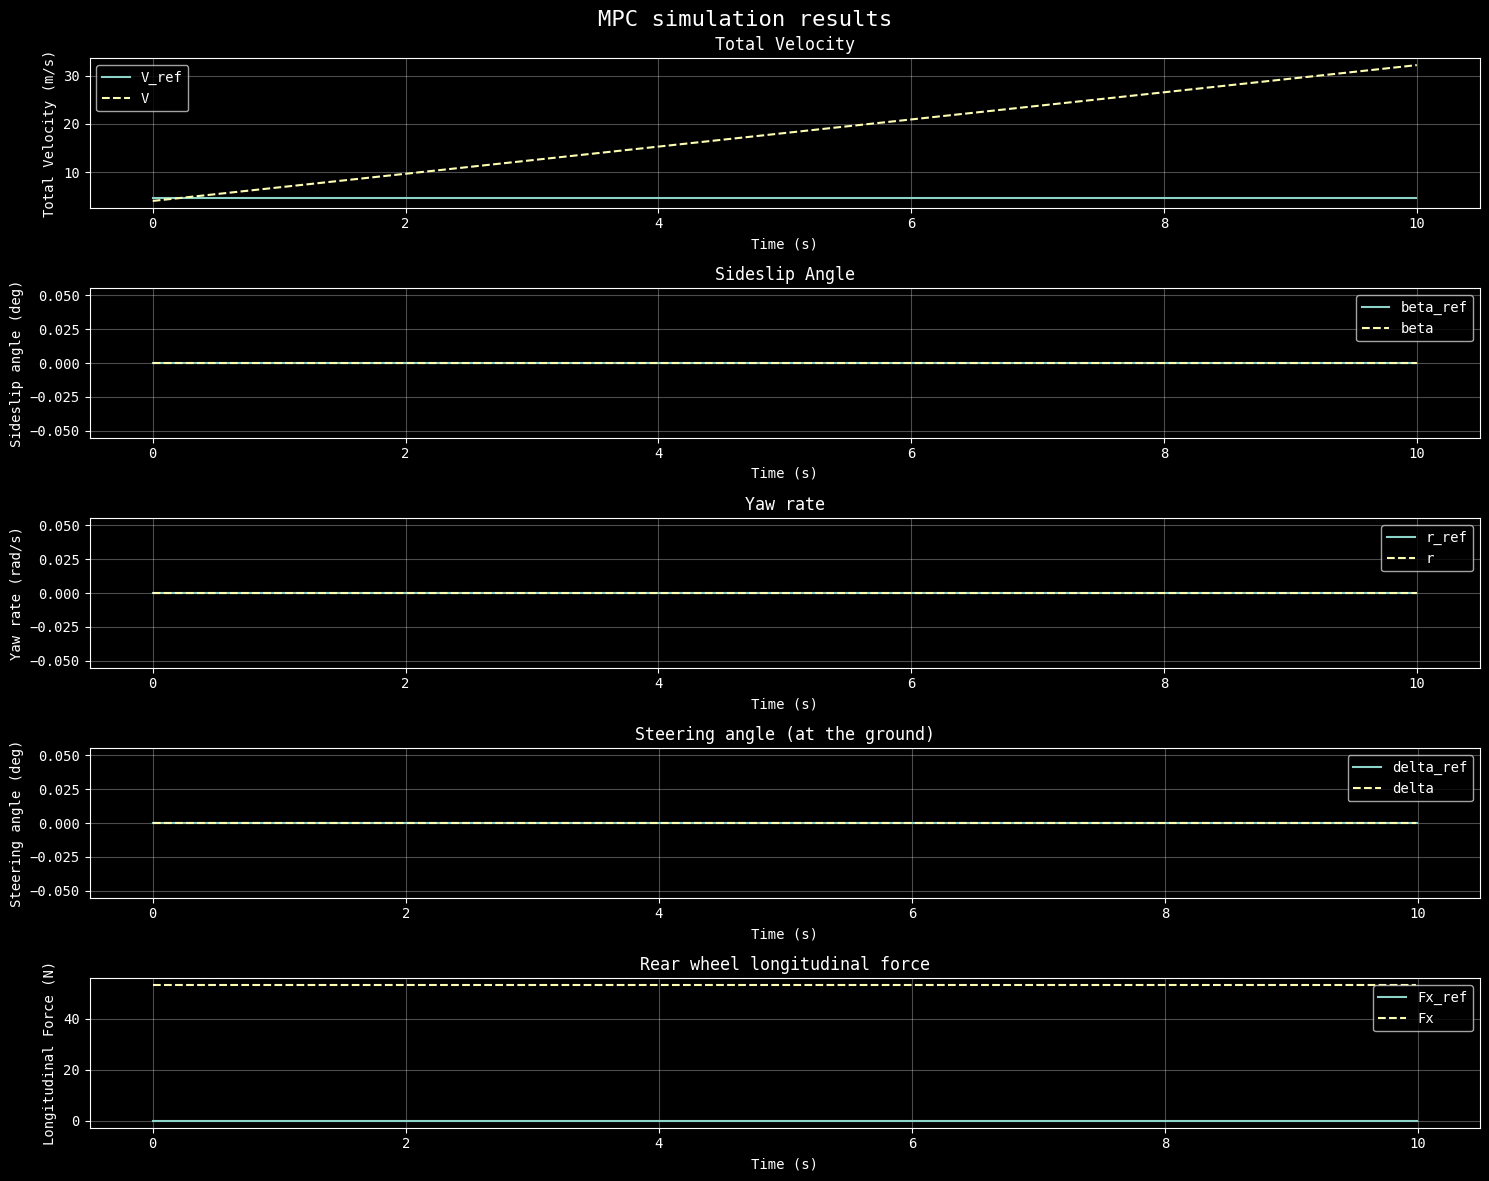

In [5]:
time        = np.linspace(0, ts_sim * N_steps, N_steps + 1)
time_mpc    = np.linspace(0, Ts * (N_steps_dt-1), N_steps_dt+1)

# plot the simulation results
CM = 'jet' #'inferno'
fig = plt.figure(figsize=(15, 12))
plt.subplot(5,1,1)
plt.plot(time_mpc, y_ref_nolookahead[:, 0], label='V_ref')
plt.plot(time, simX[:, 0], linestyle='--', label='V')
plt.title('Total Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Total Velocity (m/s)')
plt.legend()

plt.subplot(5,1,2)
plt.plot(time_mpc, np.rad2deg(y_ref_nolookahead[:, 1]), label='beta_ref')
plt.plot(time, np.rad2deg(simX[:, 1]), linestyle='--', label='beta')
plt.title('Sideslip Angle')
plt.xlabel('Time (s)')
plt.ylabel('Sideslip angle (deg)')
plt.legend()

plt.subplot(5,1,3)
plt.plot(time_mpc, np.rad2deg(y_ref_nolookahead[:, 2]), label='r_ref')
plt.plot(time, np.rad2deg(simX[:, 2]), linestyle='--', label='r')
plt.title('Yaw rate')
plt.xlabel('Time (s)')
plt.ylabel('Yaw rate (rad/s)')
plt.legend()

plt.subplot(5,1,4)
plt.plot(time_mpc, np.rad2deg(y_ref_nolookahead[:,3]), label='delta_ref')
plt.plot(time_mpc[:-1], np.rad2deg(simU[:, 0]), linestyle='--', label='delta')
plt.title('Steering angle (at the ground)')
plt.xlabel('Time (s)')
plt.ylabel('Steering angle (deg)')
# plt.ylim(np.rad2deg(delta_lb), np.rad2deg(delta_ub))
plt.legend()

plt.subplot(5,1,5)
plt.plot(time_mpc, y_ref_nolookahead[:,4], label='Fx_ref')
plt.plot(time_mpc[:-1], simU[:, 1], linestyle='--', label='Fx')
plt.title('Rear wheel longitudinal force')
plt.xlabel('Time (s)')
plt.ylabel('Longitudinal Force (N)')
# plt.ylim(Fx_lb, Fx_ub)
plt.legend()


plt.suptitle('MPC simulation results', fontsize=16)
plt.tight_layout()
plt.show()